In [2]:
import numpy as np
import pandas as pd
#viz
import matplotlib.pyplot as plt
import seaborn as sns

In [307]:
review = pd.read_csv('../data/filtered/cleaned_review_modi_5.csv')
review['month_year'] = pd.to_datetime(review[['year', 'month']].assign(DAY=1)).dt.to_period('M')

In [308]:
timeseries = review.groupby(['business_id', 'month_year']).agg({'stars': 'mean', 'text': 'count', 'useful': 'sum', 'funny': 'sum', 'cool': 'sum' })

In [309]:
timeseries

stars  text  useful  funny  cool
business_id            month_year                                     
--9e1ONYQuAa-CB_Rrw7Tw 2015-01     4.666667    12      32     18    28
                       2015-02     4.125000    16      36     35    21
                       2015-03     4.307692    13       7      6     1
                       2015-04     4.153846    13       5      3     3
                       2015-05     4.642857    14       1      1     3
...                                     ...   ...     ...    ...   ...
yhgUyctWczUN13MinNgZ3w 2017-08     2.000000    34      46      4     5
                       2017-09     1.880000    50      41      3     4
                       2017-10     2.565217    23      29     14    13
                       2017-11     2.000000    27      10      5     4
                       2017-12     2.555556     9      49     24    42

[5148 rows x 5 columns]

In [310]:
def make_lags(df, lags, cols=['stars', 'text', 'useful', 'funny', 'cool']):
    lag_array = []
    for lag in lags:
        lagged = df.groupby('business_id').shift(lag)
        lagged.columns = [f'{col}_lag_{lag}' for col in lagged.columns]
        lag_array.append(lagged)
    lags = pd.concat(lag_array, axis=1)
    return pd.concat([df, lags], axis=1)

In [311]:
lagged_df = make_lags(timeseries, np.arange(1, 13))

In [312]:
next_month = make_lags(timeseries, [-1])
next_month_avg_stars = next_month[(next_month.index.get_level_values(1) >= '2016-01') & (next_month.index.get_level_values(1) != '2017-12')][['stars_lag_-1']].rename(columns={'stars_lag_-1': 'next_month_avg_stars'})

In [313]:
final_lagged_df = pd.concat([lagged_df[(lagged_df.index.get_level_values(1) >= '2016-01') & (lagged_df.index.get_level_values(1) != '2017-12')], next_month_avg_stars], axis=1)

In [314]:
#attach business data

businesses = pd.read_csv('../data/raw/yelp_business.csv')
mybusinesses = businesses[businesses['business_id'].isin(review['business_id'])].reset_index(drop=True)

In [369]:
useful_vars = mybusinesses[['business_id', 'latitude', 'longitude', 'review_count']]

final_df = final_lagged_df.reset_index().merge(useful_vars, on='business_id').set_index(['business_id', 'month_year']).sort_index(level=1)

In [370]:
final_df

,,stars,text,useful,funny,cool,stars_lag_1,text_lag_1,useful_lag_1,funny_lag_1,cool_lag_1,...,useful_lag_12,funny_lag_12,cool_lag_12,next_month_avg_stars,latitude_x,longitude_x,review_count_x,latitude_y,longitude_y,review_count_y
business_id,month_year,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,2016-01,4.285714,14,9,5,6,4.666667,15.0,20.0,10.0,16.0,...,32.0,18.0,28.0,3.882353,36.123183,-115.169190,1451,36.123183,-115.169190,1451
-ed0Yc9on37RoIoG2ZgxBA,2016-01,4.409091,22,11,2,7,3.681818,22.0,10.0,5.0,6.0,...,22.0,5.0,7.0,3.615385,36.168802,-115.139880,1355,36.168802,-115.139880,1355
-kIscN8I29eXMPkvyyxmRQ,2016-01,4.950000,20,36,9,15,4.666667,6.0,23.0,2.0,2.0,...,24.0,6.0,9.0,4.875000,33.509589,-112.071848,637,33.509589,-112.071848,637
0FUtlsQrJI7LhqDPxLumEw,2016-01,4.789474,19,52,14,18,4.333333,15.0,24.0,0.0,1.0,...,21.0,6.0,12.0,4.600000,33.321824,-111.726057,1644,33.321824,-111.726057,1644
0W4lkclzZThpx3V65bVgig,2016-01,3.937500,32,16,6,8,4.187500,32.0,10.0,4.0,4.0,...,19.0,0.0,8.0,4.193548,45.516373,-73.577537,1953,45.516373,-73.577537,1953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xtYiHTmunjfCN2sUaQxBjA,2017-11,2.321429,28,11,9,1,2.157895,38.0,41.0,21.0,30.0,...,127.0,67.0,86.0,1.333333,36.117238,-115.187618,2080,36.117238,-115.187618,2080
yNPh5SO-7wr8HPpVCDPbXQ,2017-11,4.066667,30,13,6,8,3.961538,26.0,12.0,5.0,13.0,...,20.0,10.0,20.0,3.818182,33.447392,-112.072831,1526,33.447392,-112.072831,1526
yNVcnSaMSrTmjJBMrHTy9w,2017-11,4.388889,18,4,1,1,4.157895,19.0,5.0,1.0,3.0,...,8.0,4.0,1.0,3.111111,36.115471,-115.167920,983,36.115471,-115.167920,983


In [371]:
# timeseries test train split
from sklearn.model_selection import TimeSeriesSplit

X = final_lagged_df[final_lagged_df.index.get_level_values(1) <= '2017-07'].drop('next_month_avg_stars', axis=1)
y = final_lagged_df[final_lagged_df.index.get_level_values(1) <= '2017-07']['next_month_avg_stars']

tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [372]:
# make pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])

param_grid = {
    #'regressor__fit_intercept': [True, False],
    'regressor__alpha': [0, 0.1, 0.2],
    'regressor__l1_ratio': [0.05, 0.1, 0.15]
}

grid = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', ElasticNet())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0, 0.1, 0.2],
                         'regressor__l1_ratio': [0.05, 0.1, 0.15]},
             scoring='neg_mean_squared_error', verbose=1)

In [373]:
grid.best_params_

{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.1}

In [374]:
grid.best_score_
#elastic + business data 0.1017
#elastic 0.1047
#ridge 0.1077

-0.10175297230698459

In [385]:
# Use 2017-08 as test set
test_X = final_lagged_df[final_lagged_df.index.get_level_values(1) == '2017-08'].drop('next_month_avg_stars', axis=1)
test_y = final_lagged_df[final_lagged_df.index.get_level_values(1) == '2017-08']['next_month_avg_stars']

print("MSE: ", -grid.score(test_X, test_y))

# Rsquared

from sklearn.metrics import r2_score

print("R-squared", r2_score(test_y, grid.predict(test_X)))


MSE:  0.11009040821693132
R-squared 0.7860813104464417


In [386]:
# xgboost pipeline
from xgboost import XGBRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor())
])

param_grid = {
    'regressor': [XGBRegressor()],
    'regressor__max_depth': [2,3],
    'regressor__learning_rate': [0.1],
    'regressor__n_estimators': [100],
    'regressor__subsample': [1],
    'regressor__colsample_bytree': [1],
    'regressor__reg_alpha': [0.1, 0.2, 0.3],
}

xgb_grid = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

xgb_grid.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     featu...
                                                    monotone_constraints=None,
                                                    n_estimators=100,
                                                    n_jobs=None,
                                                    num_parallel_tree=None,
                                                    predictor=None,
                                                    random_state=None, ...)],
                         'regressor__colsample_bytree': [1],
                         'regressor__learning_rate': [0.1],
                         'regressor__max_depth': [2, 3],
                         'regressor__n_estimators': [100],
                         'regressor__reg_alpha': [0.1, 0.2, 0.3],
                         'regressor__subsample': [1]},
             scoring='neg_mean_squared_error', verbose=1)

In [387]:
xgb_grid.best_params_

{'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...),
 'regressor__colsample_bytree': 1,
 'regressor__learning_rate': 0.1,
 'regressor__max_depth': 2,
 'regressor__n_estimators': 100,
 'regressor__reg_alpha': 0.2,
 'regressor__subsample': 1}

In [388]:
#.250 - max depth 2
print('best_score: ',xgb_grid.best_score_)

best_score:  -0.11382132077111447


In [389]:
# Use 2017-08 as test set

test_X = final_lagged_df[final_lagged_df.index.get_level_values(1) == '2017-08'].drop('next_month_avg_stars', axis=1)
test_y = final_lagged_df[final_lagged_df.index.get_level_values(1) == '2017-08']['next_month_avg_stars']

print("MSE: ", -xgb_grid.score(test_X, test_y))

# Rsquared

from sklearn.metrics import r2_score

print("R-squared", r2_score(test_y, xgb_grid.predict(test_X)))


MSE:  0.11338180969045816
R-squared 0.7796857279300784


In [393]:
# Baseline model

#using the average 2017 rating
avg_2017_pred = final_lagged_df[final_lagged_df.index.get_level_values(1) == '2017-08']['stars'].mean()

print("MSE with average of all:", mean_squared_error(final_lagged_df[final_lagged_df.index.get_level_values(1) == '2017-08']['next_month_avg_stars'], np.repeat(avg_2017_pred, 143)))

#using the average rating for each business

print("MSE with previous month of each business:", mean_squared_error(final_lagged_df[final_lagged_df.index.get_level_values(1) == '2017-08']['next_month_avg_stars'], final_lagged_df[final_lagged_df.index.get_level_values(1) == '2017-08']['stars']))


MSE with average of all: 0.514678559138492
MSE with previous month of each business: 0.1802011836902856


In [4]:
def make_time_series(df, year_min=2016, year_max=2017):
    comboindex = comboindex = pd.MultiIndex.from_product([df['business_id'].unique(), np.arange(year_min, year_max+1), np.arange(1, 13)])
    initial_groupby = df.groupby(['business_id', 'year', 'month'])['stars'].agg({'stars': 'mean', 'text': 'count', 'useful': 'sum', 'funny': 'sum', 'cool': 'sum' })
    final_data = initial_groupby.reindex(comboindex)
    final_data['count'] = final_data['count'].fillna(0)
    final_data.interpolate(method='linear', inplace=True)
    final_data = final_data.reset_index().rename(
        columns={
            'mean': 'avg_stars', 
            'count': 'num_reviews',
            'level_0': 'business_id',
            'level_1': 'year',
            'level_2': 'month'
            })
    final_data['month_year'] = pd.to_datetime(final_data[['year', 'month']].assign(DAY=1)).dt.to_period('M')
    return final_data

In [5]:
def make_wide_time_series(df, columns='month_year', values=['avg_stars', 'num_reviews', 'rolling_weighted_avg_3', 'rolling_weighted_avg_6']):
    df['month_year'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    return df.pivot_table(index=['business_id'], columns=columns, values=values)

In [6]:
#rolling weighted average based on count

def weighted_average(x, df):
    try:
        return np.average(x, weights=df.loc[x.index, 'num_reviews'])
    except ZeroDivisionError:
        return np.nan


In [7]:
def rolling_weighted_average(df, window=3):
    for i in window:
        df[f'rolling_weighted_avg_{i}'] = df['avg_stars'].rolling(window=i).apply(lambda x: weighted_average(x, df), raw=False)
    return df

In [8]:
final_df = make_wide_time_series(rolling_weighted_average(make_time_series(review, year_max=2016), window=[3, 6]))
final_df.columns = final_df.columns.to_flat_index()

In [9]:
final_df

,"(avg_stars, 2016-01-01 00:00:00)","(avg_stars, 2016-02-01 00:00:00)","(avg_stars, 2016-03-01 00:00:00)","(avg_stars, 2016-04-01 00:00:00)","(avg_stars, 2016-05-01 00:00:00)","(avg_stars, 2016-06-01 00:00:00)","(avg_stars, 2016-07-01 00:00:00)","(avg_stars, 2016-08-01 00:00:00)","(avg_stars, 2016-09-01 00:00:00)","(avg_stars, 2016-10-01 00:00:00)",...,"(rolling_weighted_avg_6, 2016-03-01 00:00:00)","(rolling_weighted_avg_6, 2016-04-01 00:00:00)","(rolling_weighted_avg_6, 2016-05-01 00:00:00)","(rolling_weighted_avg_6, 2016-06-01 00:00:00)","(rolling_weighted_avg_6, 2016-07-01 00:00:00)","(rolling_weighted_avg_6, 2016-08-01 00:00:00)","(rolling_weighted_avg_6, 2016-09-01 00:00:00)","(rolling_weighted_avg_6, 2016-10-01 00:00:00)","(rolling_weighted_avg_6, 2016-11-01 00:00:00)","(rolling_weighted_avg_6, 2016-12-01 00:00:00)"
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,4.285714,3.882353,3.833333,4.200000,4.312500,4.000000,4.111111,4.466667,4.666667,3.684211,...,4.076923,4.104478,4.106667,4.085366,4.058140,4.166667,4.285714,4.172043,4.155556,4.151163
-C8S2OPEOI1fL-2Q41tWVA,3.000000,2.923077,3.428571,3.750000,4.300000,4.400000,3.909091,2.250000,1.800000,3.333333,...,3.694915,3.534483,3.677966,3.673077,3.762712,3.740741,3.596154,3.540000,3.377778,3.200000
-FLnsWAa4AGEW4NgE8Fqew,3.800000,4.250000,3.375000,4.000000,3.769231,4.214286,4.000000,4.300000,3.714286,3.000000,...,4.000000,3.896552,3.865672,3.929577,3.972973,3.972222,4.014085,3.887324,3.943662,3.888889
-_TSaVr53qiEGqMkwyEMaQ,4.818182,4.416667,4.500000,4.214286,4.625000,4.272727,3.800000,4.250000,4.000000,4.111111,...,3.307692,3.417476,3.722892,4.457143,4.304348,4.273973,4.175676,4.159420,4.088235,4.000000
-ed0Yc9on37RoIoG2ZgxBA,4.409091,3.615385,4.240000,3.956522,4.409091,3.960000,4.037037,4.206897,4.625000,4.400000,...,3.888889,3.933962,4.073171,4.083916,4.027027,4.132450,4.169014,4.231343,4.125984,4.149606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z5J9U_HU4iVLwaCH6rdC2w,3.913043,2.797872,2.958333,3.092593,3.106383,3.160000,3.448276,3.357143,3.045455,1.842105,...,3.080569,3.080769,3.053333,3.041270,3.015576,3.133333,3.185366,3.064706,3.104478,3.130769
zJGtD3y-pAIGNId4codEEg,4.333333,4.666667,4.250000,4.625000,3.625000,4.285714,3.315789,3.090909,4.200000,3.200000,...,4.097222,4.191176,4.084746,4.277778,4.000000,3.805556,3.785714,3.611111,3.610390,3.506173
zgQHtqX0gqMw1nlBZl2VnQ,3.416667,3.210526,3.636364,3.000000,3.818182,3.000000,2.761905,3.428571,3.000000,2.928571,...,3.395604,3.402174,3.454545,3.308642,3.166667,3.200000,3.109890,3.096774,3.065217,3.072289


In [10]:
january_2017_reviews = review[(review['year']==2017) & (review['month']==1)].groupby('business_id')['stars'].agg(['mean'])

In [12]:
mydata = pd.concat([final_df, january_2017_reviews], axis=1).dropna()

In [18]:
# from sktime.forecasting.arima import ARIMA
# def make_arima(df):
#     forecaster = ARIMA()
#     forecaster.fit(df)
#     return forecaster.predict(1)

In [20]:
# arima_preds = make_arima(make_time_series(review, year_max=2016).set_index(['business_id', 'month_year'])[['avg_stars']])
# arima_preds.rename(columns={'avg_stars': 'arima_preds'}, inplace=True)

c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

In [13]:
businesses = pd.read_csv('../data/raw/yelp_business.csv')
mybusinesses = businesses[businesses['business_id'].isin(mydata.index.to_list())].reset_index(drop=True)

In [41]:
mybusinesses

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,PgJgpW4TKQ8IoALH2Yq-zA,"""Bayside Buffet at Mandalay Bay""",The Strip,"""3950 S Las Vegas Blvd""",Las Vegas,NV,89109,36.091219,-115.175804,3.0,1033,1,Arts & Entertainment;Restaurants;Buffets;Ameri...
1,frCxZS7lPhEnQRJ3UY6m7A,"""La Santisima""",NaN,"""1919 N 16th St""",Phoenix,AZ,85006,33.469201,-112.047393,4.0,1694,1,Vegetarian;Nightlife;Mexican;Bars;Vegan;Restau...
2,aiX_WP7NKPTdF9CfI-M-wg,"""Culinary Dropout""",NaN,"""149 S Farmer""",Tempe,AZ,85281,33.428533,-111.943955,4.0,984,1,American (New);Restaurants
3,pyqnGlIfP9Zw8LLxBjyAiA,"""Nobu""",The Strip,"""3570 Las Vegas Blvd S""",Las Vegas,NV,89109,36.116743,-115.175368,4.0,840,1,Sushi Bars;Japanese;Seafood;Restaurants
4,cTJjTKz2huGZ-ElScC2pSw,"""Windsor""",NaN,"""5223 N Central Ave""",Phoenix,AZ,85012,33.513575,-112.073381,4.0,977,1,American (New);Bars;Food;Pubs;Nightlife;Restau...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,s0vNtuLs1cwEqHTXKiS05w,"""Babystacks Cafe""",Centennial,"""7090 N Durango Dr, Ste 140""",Las Vegas,NV,89149,36.289683,-115.286847,4.0,490,1,Hawaiian;Restaurants;American (New);Breakfast ...
393,m-xsH8VkcYtTTvp2Fa6Ajw,"""Pancho's""",South Summerlin,"""11020 Lavender Hills Dr""",Las Vegas,NV,89135,36.145418,-115.334235,3.5,531,1,Mexican;Restaurants;Breakfast & Brunch
394,01fuY2NNscttoTxOYbuZXw,"""Pinky's Westside Grill""",NaN,"""1600 W Morehead St""",Charlotte,NC,28208,35.229054,-80.867370,4.0,799,1,American (Traditional);Restaurants;Vegetarian;...
395,3xmfT7l3xNH5LK1dLzfvGw,"""Fremont Street Experience""",Downtown,"""425 Fremont St""",Las Vegas,NV,89101,36.169182,-115.141881,3.5,1311,1,Local Flavor;Casinos;Bars;Nightlife;Arts & Ent...


In [37]:
# Create bag of words for categories
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.05)
vectorized_categories = vectorizer.fit_transform(mybusinesses['categories'])
business_categories = pd.DataFrame(vectorized_categories.toarray(), columns=vectorizer.get_feature_names_out())

# One hot encode neighborhoods
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', min_frequency=0.01, sparse=False)
business_cities = enc.fit_transform(mybusinesses['city'].values.reshape(-1,1))
business_cities = pd.DataFrame(business_cities, columns=enc.get_feature_names_out())

In [77]:
#combine all features
#business_final = pd.concat([mybusinesses[['business_id', 'latitude', 'longitude']], business_categories, business_cities], axis=1)
business_final = mybusinesses[['business_id', 'latitude', 'longitude']]


In [46]:
business_final

,business_id,latitude,longitude,american,arts,asian,bars,breakfast,brunch,burgers,...,x0_Gilbert,x0_Henderson,x0_Las Vegas,x0_Montréal,x0_Phoenix,x0_Pittsburgh,x0_Scottsdale,x0_Tempe,x0_Toronto,x0_infrequent_sklearn
0,PgJgpW4TKQ8IoALH2Yq-zA,36.091219,-115.175804,1,1,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,frCxZS7lPhEnQRJ3UY6m7A,33.469201,-112.047393,0,0,0,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,aiX_WP7NKPTdF9CfI-M-wg,33.428533,-111.943955,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,pyqnGlIfP9Zw8LLxBjyAiA,36.116743,-115.175368,0,0,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,cTJjTKz2huGZ-ElScC2pSw,33.513575,-112.073381,1,0,0,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,s0vNtuLs1cwEqHTXKiS05w,36.289683,-115.286847,1,0,0,0,1,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393,m-xsH8VkcYtTTvp2Fa6Ajw,36.145418,-115.334235,0,0,0,0,1,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,01fuY2NNscttoTxOYbuZXw,35.229054,-80.867370,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,3xmfT7l3xNH5LK1dLzfvGw,36.169182,-115.141881,0,1,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.feature_extraction.text import CountVectorizer

# #make pipeline to transform data
# business_info_pipeline = ColumnTransformer([
#     ('neighborhood', OneHotEncoder(handle_unknown='ignore', min_frequency=0.05), ['city']),
#     ('categories', CountVectorizer(min_df=0.05), ['categories']),
# ],remainder='passthrough')


In [47]:
# #transform data
# business_info_pipeline.fit_transform(mybusinesses)

In [78]:
myfinaldata = pd.merge(mydata, business_final, on='business_id')

In [100]:
#sliding window splitter
from sktime.forecasting.model_selection import SlidingWindowSplitter

ts = make_time_series(review).set_index(['business_id', 'month_year'])[['avg_stars']]

#split data
sliding_window = SlidingWindowSplitter(window_length=12, fh=[1])

In [107]:
myfinaldata.columns

Index([                                  'business_id',
                    ('avg_stars', 2016-01-01 00:00:00),
                    ('avg_stars', 2016-02-01 00:00:00),
                    ('avg_stars', 2016-03-01 00:00:00),
                    ('avg_stars', 2016-04-01 00:00:00),
                    ('avg_stars', 2016-05-01 00:00:00),
                    ('avg_stars', 2016-06-01 00:00:00),
                    ('avg_stars', 2016-07-01 00:00:00),
                    ('avg_stars', 2016-08-01 00:00:00),
                    ('avg_stars', 2016-09-01 00:00:00),
                    ('avg_stars', 2016-10-01 00:00:00),
                    ('avg_stars', 2016-11-01 00:00:00),
                    ('avg_stars', 2016-12-01 00:00:00),
                  ('num_reviews', 2016-01-01 00:00:00),
                  ('num_reviews', 2016-02-01 00:00:00),
                  ('num_reviews', 2016-03-01 00:00:00),
                  ('num_reviews', 2016-04-01 00:00:00),
                  ('num_reviews', 2016-05-01 00:

In [104]:
ts.iloc[test_iloc]

,,avg_stars
business_id,month_year,
Trbt0Ex85yvwT8DHoEFCvg,2017-02,4.083333
q3dJQtwZQrrurNT-1bNKgQ,2017-02,4.222222
yhgUyctWczUN13MinNgZ3w,2017-02,2.272727
ngs16C2M_uTq2zXamltHVw,2017-02,4.736842
SVGApDPNdpFlEjwRQThCxA,2017-02,4.500000
...,...,...
CZKHXlDuy3IagC2W881fyA,2017-02,4.875000
h_4dPV9M9aYaBliH1Eoeeg,2017-02,4.333333
olmCDBoMF-EhN8U2livBSg,2017-02,4.428571


In [79]:
#train test split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(myfinaldata.drop(['mean', 'business_id'], axis=1), mydata['mean'], test_size=0.2, random_state=42)

In [82]:
#model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
#MSE: 0.1311624327731072
#R2: 0.6704877493539212

MSE: 0.13303789258592494
R2: 0.665776133605021


c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [83]:
# xgboost

import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8,)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
#MSE: 0.14418642142993382
#R2: 0.6377682905579429

MSE: 0.14429576940896716
R2: 0.6374935815737234


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

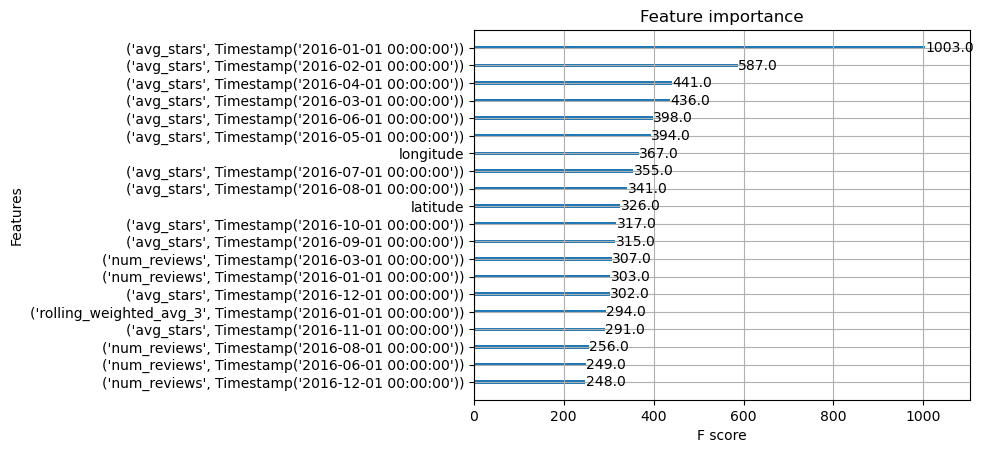

In [84]:
#plot xgboost feature importance
xgb.plot_importance(xgb_model, max_num_features=20)

In [85]:
# CART

from sklearn.tree import DecisionTreeRegressor

cart = DecisionTreeRegressor(random_state=42, max_depth=5)
cart.fit(X_train, y_train)
y_pred = cart.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MSE: 0.21121485387242425
R2: 0.46937640299963146


c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


C:\Users\Joeyz\AppData\Local\Temp\ipykernel_1596\1361023910.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


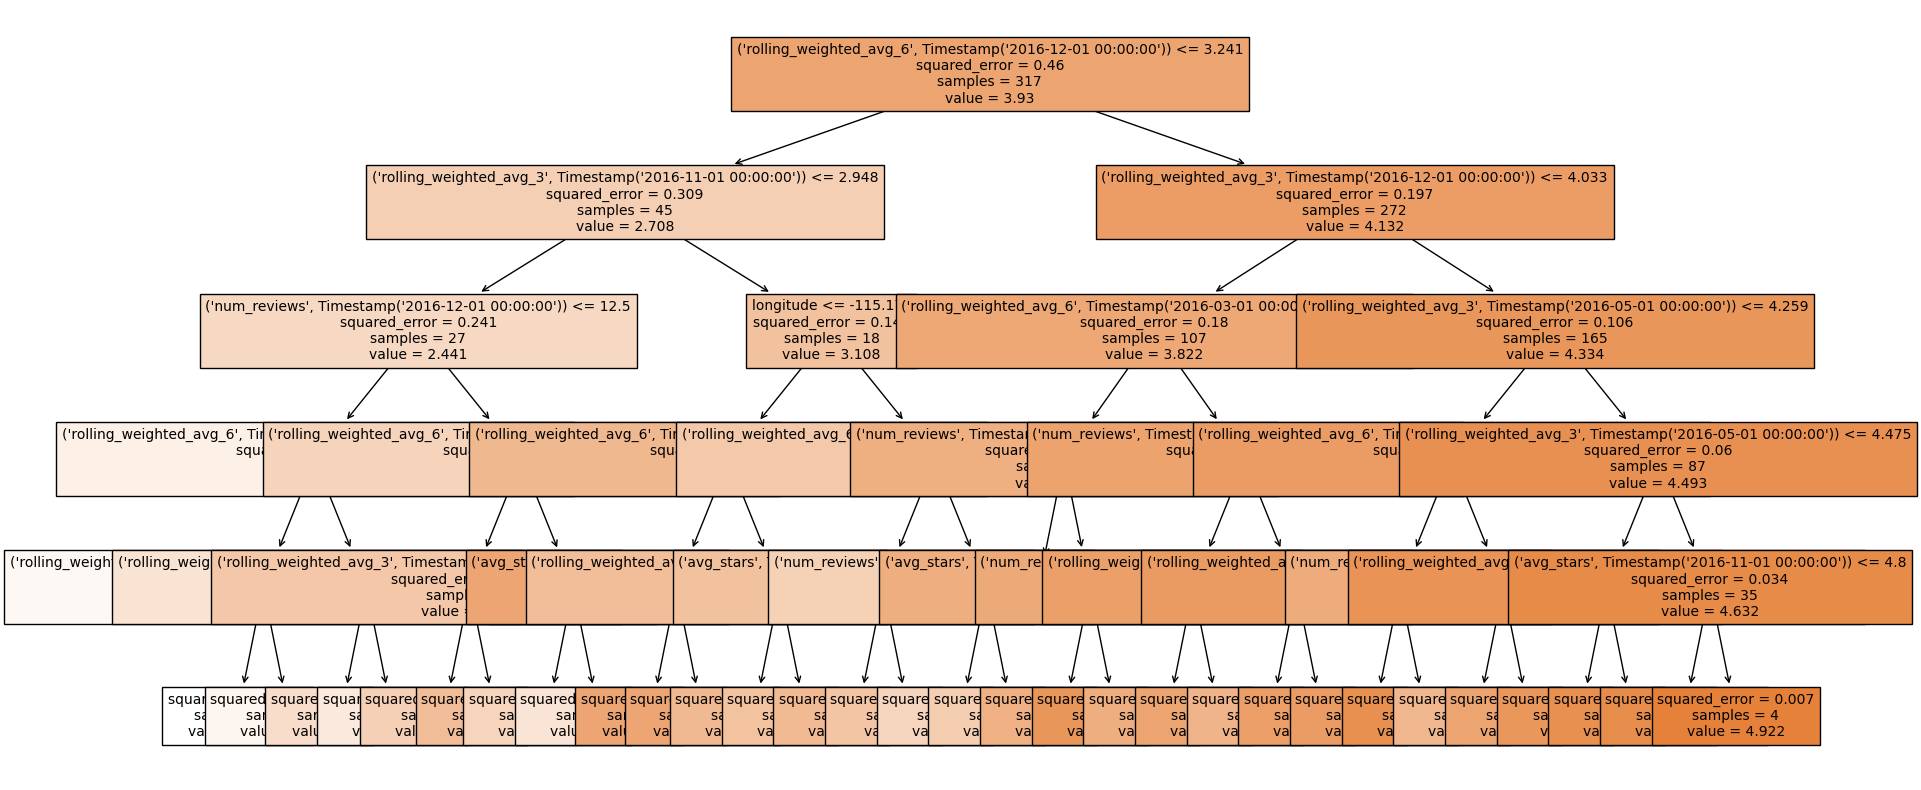

In [76]:
#plot CART tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(cart, feature_names=X_train.columns, filled=True, fontsize=10)

fig.show()

In [40]:
#arima_preds.index = arima_preds.index.droplevel(1)


testarima = arima_preds.merge(y_test, left_index=True, right_index=True)

#r2
print('MSE:', mean_squared_error(testarima['avg_stars'], testarima['mean']))
print('R2:', r2_score(testarima['mean'], testarima['avg_stars']))

MSE: 0.15791601603146344
R2: 0.6032761762996303


In [162]:
from sktime.forecasting.arima import ARIMA



In [288]:
testtimeseries = make_time_series(review, year_max=2016).set_index(['business_id', 'month_year'])[['avg_stars']][0:24]
forecastertest = ARIMA()
forecastertest.fit(testtimeseries)
forecastertest.predict(1)

,,avg_stars
business_id,month_year,
Tn8O4tv1U-n0PRC8kbJJPg,2017-01,4.474879
3RlylOY452bA8rwliPUeUQ,2017-01,2.926670


In [233]:
# try using prophet
from sktime.forecasting.fbprophet import Prophet

testtimeseries = make_time_series(review, year_max=2016)
#monthyear to datetime
testtimeseries = testtimeseries.set_index(['business_id', 'month_year'])[['avg_stars']]
testtimeseries = testtimeseries.set_index([testtimeseries.index.get_level_values(0), testtimeseries.index.get_level_values(1).to_timestamp()])
forecastertest = Prophet(uncertainty_samples=0)

In [234]:
forecastertest.fit(testtimeseries)

21:05:16 - cmdstanpy - INFO - Chain [1] start processing
21:05:16 - cmdstanpy - INFO - Chain [1] done processing
21:05:16 - cmdstanpy - INFO - Chain [1] start processing
21:05:16 - cmdstanpy - INFO - Chain [1] done processing
21:05:16 - cmdstanpy - INFO - Chain [1] start processing
21:05:16 - cmdstanpy - INFO - Chain [1] done processing
21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:17 - cmdstanpy - INFO - Chain [1] done processing
21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:17 - cmdstanpy - INFO - Chain [1] done processing
21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:17 - cmdstanpy - INFO - Chain [1] done processing
21:05:18 - cmdstanpy - INFO - Chain [1] start processing
21:05:18 - cmdstanpy - INFO - Chain [1] done processing
21:05:18 - cmdstanpy - INFO - Chain [1] start processing
21:05:18 - cmdstanpy - INFO - Chain [1] done processing
21:05:18 - cmdstanpy - INFO - Chain [1] start processing
21:05:19 - cmdstanpy - INFO - Chain [1]

Prophet(uncertainty_samples=0)

In [266]:
combo_test

NameError: name 'combo_test' is not defined

In [269]:
#calculate R squared
from sklearn.metrics import r2_score
predictions = forecastertest.predict(pd.DatetimeIndex(['2017-01-01']))
testtester = make_time_series(review, year_min=2017, year_max=2017)

-1.1545706173786239

In [275]:
combo = testtester[testtester['month_year'] == '2017-01-01'].copy().reset_index(drop=True)
combo['pred'] = predictions.reset_index()['avg_stars']
combo_test = combo.dropna()
y_true = combo_test['avg_stars']
y_pred = combo_test['pred']
r2_score(y_true, y_pred)

-0.0016295754903783433

In [287]:
review[(review['business_id']=='An-JJle53UMHokU4MwFktg') & (review['year']==2016) & (review['month']==9)]

,business_id,date,year,month,stars,text,useful,funny,cool,monthyear
74912,An-JJle53UMHokU4MwFktg,2016-09-12,2016,9,1,This location is not as good as the hwy 7 loca...,3,1,3,2016-09


In [277]:
predictions

,,avg_stars
business_id,month_year,
Tn8O4tv1U-n0PRC8kbJJPg,2017-01-01,4.491886
3RlylOY452bA8rwliPUeUQ,2017-01-01,2.641096
An-JJle53UMHokU4MwFktg,2017-01-01,2.103792
ZilzayEdyk70SoI-wruJbg,2017-01-01,3.202901
kKNauD7d3HOvumRV7JIAfg,2017-01-01,4.387206
...,...,...
lxunwc4AHLJ_MaDVRlUyEw,2017-01-01,4.119020
1oD3ndgNI997hTEqkEh8EA,2017-01-01,1.350551
ZdaZwXC0FByDY3EwNELphw,2017-01-01,4.708986


In [276]:
combo

,business_id,year,month,num_reviews,avg_stars,month_year,pred
0,Tn8O4tv1U-n0PRC8kbJJPg,2017,1,0.0,NaN,2017-01,4.491886
1,3RlylOY452bA8rwliPUeUQ,2017,1,3.0,3.000000,2017-01,2.641096
2,An-JJle53UMHokU4MwFktg,2017,1,7.0,3.714286,2017-01,2.103792
3,ZilzayEdyk70SoI-wruJbg,2017,1,2.0,3.500000,2017-01,3.202901
4,kKNauD7d3HOvumRV7JIAfg,2017,1,5.0,4.000000,2017-01,4.387206
...,...,...,...,...,...,...,...
922,lxunwc4AHLJ_MaDVRlUyEw,2017,1,2.0,3.500000,2017-01,4.119020
923,1oD3ndgNI997hTEqkEh8EA,2017,1,2.0,3.500000,2017-01,1.350551
924,ZdaZwXC0FByDY3EwNELphw,2017,1,3.0,4.666667,2017-01,4.708986
925,0Yh6U06nGLjAMwCw6l9-DA,2017,1,6.0,2.166667,2017-01,3.762257


,business_id,year,month,num_reviews,avg_stars,month_year,pred
12,3RlylOY452bA8rwliPUeUQ,2017,1,3.0,3.000000,2017-01,3.909685
24,An-JJle53UMHokU4MwFktg,2017,1,7.0,3.714286,2017-01,2.432368
36,ZilzayEdyk70SoI-wruJbg,2017,1,2.0,3.500000,2017-01,3.033997
48,kKNauD7d3HOvumRV7JIAfg,2017,1,5.0,4.000000,2017-01,4.184124
60,TR0-w6VoZDAdvFQiq7P2Ug,2017,1,7.0,4.285714,2017-01,4.061316
...,...,...,...,...,...,...,...
11064,lxunwc4AHLJ_MaDVRlUyEw,2017,1,2.0,3.500000,2017-01,NaN
11076,1oD3ndgNI997hTEqkEh8EA,2017,1,2.0,3.500000,2017-01,NaN
11088,ZdaZwXC0FByDY3EwNELphw,2017,1,3.0,4.666667,2017-01,NaN
11100,0Yh6U06nGLjAMwCw6l9-DA,2017,1,6.0,2.166667,2017-01,NaN


In [ ]:
test

In [227]:
# get actual values
testsettest = make_time_series(review, year_max=2017)

testsettest[testsettest['month_year']=='2017-01']

,business_id,year,month,num_reviews,avg_stars,month_year
12,Tn8O4tv1U-n0PRC8kbJJPg,2017,1,0.0,5.000000,2017-01
36,3RlylOY452bA8rwliPUeUQ,2017,1,3.0,3.000000,2017-01
60,An-JJle53UMHokU4MwFktg,2017,1,7.0,3.714286,2017-01
84,ZilzayEdyk70SoI-wruJbg,2017,1,2.0,3.500000,2017-01
108,kKNauD7d3HOvumRV7JIAfg,2017,1,5.0,4.000000,2017-01
...,...,...,...,...,...,...
22140,lxunwc4AHLJ_MaDVRlUyEw,2017,1,2.0,3.500000,2017-01
22164,1oD3ndgNI997hTEqkEh8EA,2017,1,2.0,3.500000,2017-01
22188,ZdaZwXC0FByDY3EwNELphw,2017,1,3.0,4.666667,2017-01
22212,0Yh6U06nGLjAMwCw6l9-DA,2017,1,6.0,2.166667,2017-01


In [166]:
testtimeseries

avg_stars
business_id            month_year           
Tn8O4tv1U-n0PRC8kbJJPg 2016-02-01   5.000000
                       2016-03-01   4.200000
                       2016-04-01   4.400000
                       2016-05-01   4.700000
                       2016-06-01   5.000000
                       2016-07-01   4.000000
                       2016-08-01   4.000000
                       2016-09-01   4.333333
                       2016-10-01   4.333333
                       2016-11-01   4.500000
                       2016-12-01   5.000000
3RlylOY452bA8rwliPUeUQ 2016-01-01   3.000000
                       2016-02-01   2.500000
                       2016-03-01   2.000000
                       2016-04-01   4.000000
                       2016-05-01   3.000000
                       2016-06-01   5.000000
                       2016-07-01   3.500000
                       2016-08-01   3.333333
                       2016-09-01   4.500000
                       2016-10-01   2.000000
                       2016-11-01   1.000000
                       2016-12-01   2.500000

In [ ]:
forecaster = ARIMA()
forecaster.fit(

In [ ]:
fh = [1]
y = df[df['month_year'] < '2017-01-01'].set_index(['business_id','month'])[['avg_stars']]
#y = review[review['year']==2016].groupby(['business_id', 'month'])[['stars']].mean()
forecaster = ARIMA()
forecaster.fit(y, fh=fh)
arima_pred = forecaster.predict()

In [149]:
make_time_series(review)

,business_id,year,month,num_reviews,avg_stars,month_year
0,Tn8O4tv1U-n0PRC8kbJJPg,2016,1,3.0,4.333333,2016-01-01
1,Tn8O4tv1U-n0PRC8kbJJPg,2016,2,1.0,5.000000,2016-02-01
2,Tn8O4tv1U-n0PRC8kbJJPg,2016,3,5.0,4.200000,2016-03-01
3,Tn8O4tv1U-n0PRC8kbJJPg,2016,4,5.0,4.400000,2016-04-01
4,Tn8O4tv1U-n0PRC8kbJJPg,2016,5,0.0,4.700000,2016-05-01
...,...,...,...,...,...,...
22243,dulgBrNtDCGjYcbQa2E6uA,2017,8,2.0,3.000000,2017-08-01
22244,dulgBrNtDCGjYcbQa2E6uA,2017,9,1.0,5.000000,2017-09-01
22245,dulgBrNtDCGjYcbQa2E6uA,2017,10,1.0,3.000000,2017-10-01
22246,dulgBrNtDCGjYcbQa2E6uA,2017,11,3.0,5.000000,2017-11-01


In [4]:
business_info = pd.read_csv('../data/processed/business_info.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/business_info.csv'

In [11]:
#make monthyear column
review['monthyear'] = pd.to_datetime(review['date']).dt.to_period('M')

In [12]:
df = make_time_series(review)

In [7]:
df['month_year'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

In [9]:
df.set_index(['month_year'])[['avg_stars']]

,avg_stars
month_year,
2016-01-01,4.333333
2016-02-01,5.000000
2016-03-01,4.200000
2016-04-01,4.400000
2016-05-01,4.700000
...,...
2017-08-01,3.000000
2017-09-01,5.000000
2017-10-01,3.000000


In [103]:
df[df['month_year'] < '2017-01-01'].set_index(['business_id','month_year'])[['avg_stars']]

avg_stars
business_id            month_year           
Tn8O4tv1U-n0PRC8kbJJPg 2016-01-01   4.333333
                       2016-02-01   5.000000
                       2016-03-01   4.200000
                       2016-04-01   4.400000
                       2016-05-01   4.700000
...                                      ...
dulgBrNtDCGjYcbQa2E6uA 2016-08-01   5.000000
                       2016-09-01   2.000000
                       2016-10-01   2.000000
                       2016-11-01   2.000000
                       2016-12-01   1.500000

[11124 rows x 1 columns]

In [87]:
from sktime.forecasting.arima import ARIMA

In [115]:
df[df['month_year'] < '2017-01-01'].set_index(['business_id','month'])[['avg_stars']].iloc[0:24]

avg_stars
business_id            month           
Tn8O4tv1U-n0PRC8kbJJPg 1       4.333333
                       2       5.000000
                       3       4.200000
                       4       4.400000
                       5       4.700000
                       6       5.000000
                       7       4.000000
                       8       4.000000
                       9       4.333333
                       10      4.333333
                       11      4.500000
                       12      5.000000
3RlylOY452bA8rwliPUeUQ 1       3.000000
                       2       2.500000
                       3       2.000000
                       4       4.000000
                       5       3.000000
                       6       5.000000
                       7       3.500000
                       8       3.333333
                       9       4.500000
                       10      2.000000
                       11      1.000000
                       12      2.500000

In [138]:
review[review['year']==2016].groupby(['business_id', 'monthyear'])['stars'].agg(['mean'])

mean
business_id            monthyear          
-0NrB58jqKqJfuUCDupcsw 2016-01    4.000000
                       2016-02    3.750000
                       2016-03    3.000000
                       2016-04    3.500000
                       2016-06    2.000000
...                                    ...
zs-T0uqKSHhYWSEok6oouw 2016-08    3.750000
                       2016-09    4.500000
                       2016-10    2.000000
                       2016-11    3.333333
                       2016-12    2.000000

[9931 rows x 1 columns]

In [233]:
fh = [1]
y = df[df['month_year'] < '2017-01-01'].set_index(['business_id','month'])[['avg_stars']]
#y = review[review['year']==2016].groupby(['business_id', 'month'])[['stars']].mean()
forecaster = ARIMA()
forecaster.fit(y, fh=fh)
arima_pred = forecaster.predict()

c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Miniconda3\envs\edge_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: Val

In [176]:
y_pred #new

,,stars
business_id,month,
-0NrB58jqKqJfuUCDupcsw,13,3.418270
-BbnAc9YEO6pjvJGEtFbVQ,13,4.254936
-CLTZ0cO-ooKDDmXHFoGMg,13,4.460366
-I7Vz5eDjc63xKmmt4Qx4g,13,2.751366
-ICGmF2qUVKdvOehVNgPbg,13,4.621367
...,...,...
zfQ855VX3SMA_54oVSN5Cw,12,4.371127
zgQHtqX0gqMw1nlBZl2VnQ,13,3.334295
zo_z6lMRcwHqQF_Z1VZLpg,13,2.720471


In [154]:
y_pred #old

,,mean,count
business_id,monthyear,,
-0NrB58jqKqJfuUCDupcsw,2017-01,3.418270,2.311116
-BbnAc9YEO6pjvJGEtFbVQ,2017-01,4.254936,6.123945
-CLTZ0cO-ooKDDmXHFoGMg,2017-01,4.460366,7.754339
-I7Vz5eDjc63xKmmt4Qx4g,2017-01,2.751366,4.530870
-ICGmF2qUVKdvOehVNgPbg,2017-01,4.621367,4.988006
...,...,...,...
zfQ855VX3SMA_54oVSN5Cw,2016-12,4.371127,5.111209
zgQHtqX0gqMw1nlBZl2VnQ,2017-01,3.334295,12.367541
zo_z6lMRcwHqQF_Z1VZLpg,2017-01,2.720471,4.141444


In [140]:
y_test = df[df['month_year'] == '2017-01-01'].sort_values('business_id')

In [167]:
y_test

,business_id,year,month,num_reviews,avg_stars,month_year
21828,-0NrB58jqKqJfuUCDupcsw,2017,1,0.0,3.050000,2017-01-01
8460,-BbnAc9YEO6pjvJGEtFbVQ,2017,1,6.0,4.500000,2017-01-01
17652,-CLTZ0cO-ooKDDmXHFoGMg,2017,1,4.0,3.500000,2017-01-01
20820,-I7Vz5eDjc63xKmmt4Qx4g,2017,1,2.0,2.500000,2017-01-01
7740,-ICGmF2qUVKdvOehVNgPbg,2017,1,6.0,4.666667,2017-01-01
...,...,...,...,...,...,...
15948,zfQ855VX3SMA_54oVSN5Cw,2017,1,0.0,4.666667,2017-01-01
3012,zgQHtqX0gqMw1nlBZl2VnQ,2017,1,16.0,3.000000,2017-01-01
1908,zo_z6lMRcwHqQF_Z1VZLpg,2017,1,0.0,3.333333,2017-01-01
17340,zrYpLdnGKA_EmOhgRCy_vg,2017,1,2.0,4.000000,2017-01-01


In [182]:
y_pred.sort_index()

,,avg_stars
business_id,month,
-0NrB58jqKqJfuUCDupcsw,13,3.166185
-BbnAc9YEO6pjvJGEtFbVQ,13,4.254936
-CLTZ0cO-ooKDDmXHFoGMg,13,4.705053
-I7Vz5eDjc63xKmmt4Qx4g,13,2.887402
-ICGmF2qUVKdvOehVNgPbg,13,4.621367
...,...,...
zfQ855VX3SMA_54oVSN5Cw,13,4.305188
zgQHtqX0gqMw1nlBZl2VnQ,13,3.334295
zo_z6lMRcwHqQF_Z1VZLpg,13,2.720471


In [183]:
#calculate R2 score

from sklearn.metrics import r2_score

r2_score(y_test['avg_stars'], y_pred.sort_index())
#0.18 - (1,0,0)
#0.13 - using monthyear



0.18554472521207976

In [194]:
y_test

,business_id,year,month,num_reviews,avg_stars,month_year
21828,-0NrB58jqKqJfuUCDupcsw,2017,1,0.0,3.050000,2017-01-01
8460,-BbnAc9YEO6pjvJGEtFbVQ,2017,1,6.0,4.500000,2017-01-01
17652,-CLTZ0cO-ooKDDmXHFoGMg,2017,1,4.0,3.500000,2017-01-01
20820,-I7Vz5eDjc63xKmmt4Qx4g,2017,1,2.0,2.500000,2017-01-01
7740,-ICGmF2qUVKdvOehVNgPbg,2017,1,6.0,4.666667,2017-01-01
...,...,...,...,...,...,...
15948,zfQ855VX3SMA_54oVSN5Cw,2017,1,0.0,4.666667,2017-01-01
3012,zgQHtqX0gqMw1nlBZl2VnQ,2017,1,16.0,3.000000,2017-01-01
1908,zo_z6lMRcwHqQF_Z1VZLpg,2017,1,0.0,3.333333,2017-01-01
17340,zrYpLdnGKA_EmOhgRCy_vg,2017,1,2.0,4.000000,2017-01-01


In [208]:
#Try with just ussng them as features

x_train = df[df['month_year']<'2017-01'].set_index(['business_id','month_year'])[['avg_stars']].unstack(level=1).sort_index()

In [209]:
x_train

avg_stars                                              \
month_year             2016-01-01 2016-02-01 2016-03-01 2016-04-01 2016-05-01   
business_id                                                                     
-0NrB58jqKqJfuUCDupcsw   4.000000   3.750000   3.000000   3.500000   2.750000   
-BbnAc9YEO6pjvJGEtFbVQ   4.000000   4.555556   4.333333   4.000000   4.500000   
-CLTZ0cO-ooKDDmXHFoGMg   4.055556   4.111111   4.166667   4.222222   4.277778   
-I7Vz5eDjc63xKmmt4Qx4g   3.142857   3.107143   3.071429   3.035714   3.000000   
-ICGmF2qUVKdvOehVNgPbg   4.250000   4.875000   3.285714   5.000000   4.500000   
...                           ...        ...        ...        ...        ...   
zfQ855VX3SMA_54oVSN5Cw   3.666667   4.500000   4.000000   4.285714   4.333333   
zgQHtqX0gqMw1nlBZl2VnQ   3.416667   3.210526   3.636364   3.000000   3.818182   
zo_z6lMRcwHqQF_Z1VZLpg   2.000000   4.000000   1.666667   3.500000   1.750000   
zrYpLdnGKA_EmOhgRCy_vg   4.000000   3.333333   4.500000   4.000000   4.666667   
zs-T0uqKSHhYWSEok6oouw   4.166667   3.333333   4.000000   3.375000   2.750000   

                                                                               \
month_year             2016-06-01 2016-07-01 2016-08-01 2016-09-01 2016-10-01   
business_id                                                                     
-0NrB58jqKqJfuUCDupcsw   2.000000   3.500000   3.000000      3.750   4.000000   
-BbnAc9YEO6pjvJGEtFbVQ   3.500000   4.500000   4.625000      4.500   4.000000   
-CLTZ0cO-ooKDDmXHFoGMg   4.333333   3.571429   3.333333      4.000   4.125000   
-I7Vz5eDjc63xKmmt4Qx4g   3.090909   2.250000   2.600000      3.000   2.000000   
-ICGmF2qUVKdvOehVNgPbg   4.333333   5.000000   4.166667      4.375   4.200000   
...                           ...        ...        ...        ...        ...   
zfQ855VX3SMA_54oVSN5Cw   4.750000   5.000000   4.000000      4.750   4.000000   
zgQHtqX0gqMw1nlBZl2VnQ   3.000000   2.761905   3.428571      3.000   2.928571   
zo_z6lMRcwHqQF_Z1VZLpg   1.250000   3.000000   2.000000      3.375   4.000000   
zrYpLdnGKA_EmOhgRCy_vg   4.000000   2.333333   3.166667      4.000   3.500000   
zs-T0uqKSHhYWSEok6oouw   3.800000   2.666667   3.750000      4.500   2.000000   

                                              
month_year             2016-11-01 2016-12-01  
business_id                                   
-0NrB58jqKqJfuUCDupcsw   3.666667   2.500000  
-BbnAc9YEO6pjvJGEtFbVQ   4.000000   3.600000  
-CLTZ0cO-ooKDDmXHFoGMg   4.562500   5.000000  
-I7Vz5eDjc63xKmmt4Qx4g   3.666667   3.000000  
-ICGmF2qUVKdvOehVNgPbg   5.000000   4.142857  
...                           ...        ...  
zfQ855VX3SMA_54oVSN5Cw   4.000000   4.333333  
zgQHtqX0gqMw1nlBZl2VnQ   3.600000   3.000000  
zo_z6lMRcwHqQF_Z1VZLpg   3.200000   2.666667  
zrYpLdnGKA_EmOhgRCy_vg   4.000000   4.000000  
zs-T0uqKSHhYWSEok6oouw   3.333333   2.000000  

[927 rows x 12 columns]

In [210]:
#linear regression

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_test['avg_stars'])

LinearRegression()

In [213]:
r2_score(y_test['avg_stars'], y_pred)

0.2755915931253775

In [217]:
# train test split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_test['avg_stars'], test_size=0.2, random_state=42)

In [232]:
# try xgboost

import xgboost as xgb

xgb_model = xgb.XGBRegressor(max_depth=6)
xgb_model.fit(x_train, y_train)

r2_score(y_test, xgb_model.predict(x_test))

0.14536890587849294

In [226]:
#mse

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, xgb_model.predict(x_test))

0.5989938895791203

In [225]:
r2_score(y_train, xgb_model.predict(x_train))

0.9997983706628545

In [21]:
comboindex = pd.MultiIndex.from_product([review['business_id'].unique(), np.arange(2016, 2018), np.arange(1, 13)])

In [25]:
initial_groupby = review.groupby(['business_id', 'year', 'month'])['stars'].agg(['count', 'mean'])

In [41]:
final_data = initial_groupby.reindex(comboindex)

In [42]:
final_data['count'] = final_data['count'].fillna(0)
final_data.interpolate(method='linear', inplace=True)

In [4]:
attribute=pd.read_csv("../data/filtered/business_attributes_on.csv")
hour=pd.read_csv("../data/filtered/business_hours_on.csv")
business_hours=pd.read_csv("../data/filtered/check_in_on.csv")
restaurant=pd.read_csv("../data/filtered/res_on.csv")
review=pd.read_csv("../data/filtered/review_res_on.csv")
tip=pd.read_csv("../data/filtered/tip_on.csv")
user=pd.read_csv("../data/filtered/user_res_on.csv")

In [5]:
def clean_df(review):
    # select only year 2015, 2016, 2017
    review.loc[:, ('date')] = pd.to_datetime(review['date'])
    review.loc[:, ('year')] = review['date'].dt.year
    review.loc[:, ('month')] = review['date'].dt.month
    review = review[review['year'] > 2014]
    review = review[['business_id','date','year','month','stars','text','useful','funny','cool']]
    
    # filter restaurants that have at least 20+ reviews in 2015 & 2016 & 2017
    reviews_2015 = review[review['year'] == 2015]
    reviews_2016 = review[review['year'] == 2016]
    reviews_2017 = review[review['year'] == 2017]
    
    over_20_reviews_2015 = reviews_2015['business_id'].value_counts()[reviews_2015['business_id'].value_counts() >= 20].index.tolist()
    over_20_reviews_2016 = reviews_2016['business_id'].value_counts()[reviews_2016['business_id'].value_counts() >= 20].index.tolist()
    over_20_reviews_2017 = reviews_2017['business_id'].value_counts()[reviews_2017['business_id'].value_counts() >= 20].index.tolist()

    in_2015 = set(over_20_reviews_2015)
    in_2016 = set(over_20_reviews_2016)
    in_2017 = set(over_20_reviews_2017)
    
    intersection = list(in_2015 & in_2016 & in_2017)

    review = review[review['business_id'].isin(intersection)]
    
    return review

In [6]:
def export_df(dataframe):
    dataframe = dataframe.drop(columns={'month','date'})
    names = ['2015_text','2015_rate','2016_text','2016_rate','2017_text','2017_rate']
    years = [2015, 2016, 2017]
    new_df = pd.DataFrame(columns=names)
    
    # extract business ids in the dataframe
    # (note: should be the same as 'in_all_3yrs')
    bus_id_list = dataframe['business_id'].unique().tolist()
    
    for res in bus_id_list:
        df_res = dataframe[dataframe.business_id == res]
        df_des = df_res.groupby('year')['stars'].mean().reset_index(drop=True)
        res_info = []

        for yr in years:
            df_res_temp = df_res[df_res['year']==yr]
            df_res_temp = df_res_temp.drop(columns={'business_id','year'})
            res_yr_rate = df_res[df_res['year']==yr]['stars'].mean()
            res_info.append(df_res_temp)
            res_info.append(res_yr_rate)

        new_df.loc[res] = res_info
        
    new_df.index.names = ['business_id']
    new_df = new_df.reset_index(drop=True)
        
    return new_df

In [7]:
review1 = clean_df(review)
review2 = export_df(review1)

In [139]:
len(review2)

648

In [13]:
review2['2015_text'][0].head()

,stars,text,useful,funny,cool
11587,3,"Very very cheap place, really. You got sausage...",0,0,0
22879,3,Very cheap banh mi. I didn't think it was that...,1,0,0
35709,5,My go to for take out comfort food. It can get...,0,0,0
76459,5,SO MUCH LOVE FOR THIS PLACE!!! It's only $2.75...,0,0,2
92386,4,They have the best sandwiches for the price. Y...,0,0,0


In [14]:
review2.isna().any()

2015_text    False
2015_rate    False
2016_text    False
2016_rate    False
2017_text    False
2017_rate    False
dtype: bool

## tfidf

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
from bs4 import BeautifulSoup
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, FastText

In [143]:
# remove numbers
def remove_num(text):
    text_nonum = re.sub(r'\d+', '', text)
    text_nopunct = "".join([char.lower() for char in str(text_nonum) if char not in string.punctuation])
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_nonum

# remove_special_characters
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

# remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if str(i) not in string.punctuation])
    return punctuationfree

#  tokenization
def tokenization(text):
    tokens = re.split(' +',text)
    return tokens

# remove stopwords
nltk.download('stopwords')
my_stopwords = stopwords.words('english')
my_stopwords.remove('be') # BE -> Back Ends
def rm_stopwords(text):
  return [i for i in text if i not in my_stopwords]

# lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatization(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

# remove_extra_whitespace_tabs
def remove_extra_whitespace_tabs(text):
    #pattern = r'^\s+$|\s+$'
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/qinwenw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/qinwenw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/qinwenw/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [178]:
def tfidf_pca(df, n): # n: number of component for PCA
    df.loc[:,('text_clean')] = df['text'].apply(
        lambda x: lemmatization(rm_stopwords(tokenization(remove_punctuation(remove_extra_whitespace_tabs(remove_num(remove_special_characters(x.lower())))))))
    )
    df.loc[:,('text_clean_str')] = df['text_clean'].apply(lambda x: ' '.join(x))
    df = df.sort_values(by='business_id').reset_index(drop=True)
    
    # TFIDF
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df['text_clean_str'])
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    df_tfidf = pd.DataFrame(denselist, columns=feature_names)
    
    # PCA
    pca = PCA(n_components=n)
    text_pca = pca.fit_transform(df_tfidf)
    temp = pd.DataFrame(text_pca)
    
    temp.columns = ['text_pca'+str(i) for i in range(1,n+1)]
    df =  pd.concat([df, temp], axis=1)
    
    return df

In [182]:
review1_2015 = review1[review1['year']==2015].sort_values(by='business_id')

In [183]:
review1_2015_vec = tfidf_pca(review1_2015,5)

In [184]:
review1_2015_vec.head()

,business_id,date,year,month,stars,text,useful,funny,cool,text_clean,text_clean_str,text_pca1,text_pca2,text_pca3,text_pca4,text_pca5
0,-0NrB58jqKqJfuUCDupcsw,2015-04-21,2015,4,5,"There is hype I know, but it really IS THAT go...",1,0,0,"[hype, know, really, good, several, time, star...",hype know really good several time starting ov...,-0.008541,-0.013594,0.009846,0.005136,0.026575
1,-0NrB58jqKqJfuUCDupcsw,2015-08-18,2015,8,5,Very delicious food. Too much food for me haha...,0,0,0,"[delicious, food, much, food, hahaha, service,...",delicious food much food hahaha service good o...,0.057771,0.012714,0.020116,-0.024486,0.111824
2,-0NrB58jqKqJfuUCDupcsw,2015-07-01,2015,7,3,Best friend and I decided to hang out after ou...,2,0,0,"[best, friend, decided, hang, movie, found, li...",best friend decided hang movie found little sp...,0.029395,0.011791,-0.024404,0.032245,-0.040576
3,-0NrB58jqKqJfuUCDupcsw,2015-11-25,2015,11,4,Korean fried chicken can't go wrong. their bat...,0,0,0,"[korean, fried, chicken, cant, go, wrong, batt...",korean fried chicken cant go wrong batter thic...,-0.053239,0.134091,-0.065809,-0.111815,0.032089
4,-0NrB58jqKqJfuUCDupcsw,2015-10-11,2015,10,4,Came here on a Friday night and it was pretty ...,0,0,0,"[came, friday, night, pretty, packed, luckily,...",came friday night pretty packed luckily got em...,-0.123059,-0.063500,-0.084363,-0.024051,0.036432


In [186]:
review1_2016_jan = review1[(review1['year']==2016) & review1['month']==1].sort_values(by='business_id')

In [195]:
review1_2016_jan_vec = tfidf_pca(review1_2016_jan,5)

In [196]:
review1_2016_jan_vec.head()

,business_id,date,year,month,stars,text,useful,funny,cool,text_clean,text_clean_str,text_pca1,text_pca2,text_pca3,text_pca4,text_pca5
0,-0NrB58jqKqJfuUCDupcsw,2016-09-25,2016,9,2,The service was slow and not attentive. The wa...,1,0,0,"[service, slow, attentive, waitress, didnt, of...",service slow attentive waitress didnt offer br...,0.047904,-0.020134,-0.086337,-0.038422,-0.119714
1,-0NrB58jqKqJfuUCDupcsw,2016-07-06,2016,7,3,A good place to fulfill a fried chicken fix. I...,2,0,1,"[good, place, fulfill, fried, chicken, fix, iv...",good place fulfill fried chicken fix ive korea...,0.142944,-0.049254,-0.078695,-0.137127,-0.198242
2,-0NrB58jqKqJfuUCDupcsw,2016-03-27,2016,3,5,Great service especially if you bring a Korean...,1,0,1,"[great, service, especially, bring, koreanspea...",great service especially bring koreanspeaking ...,0.102288,-0.127845,-0.016310,-0.159451,-0.232646
3,-0NrB58jqKqJfuUCDupcsw,2016-11-23,2016,11,4,"Delicious food, okay service.\n\nI tried Korea...",1,0,0,"[delicious, food, okay, service, tried, korean...",delicious food okay service tried korean fried...,0.099417,0.014488,-0.084756,-0.025352,-0.116971
4,-0NrB58jqKqJfuUCDupcsw,2016-01-17,2016,1,4,The fried chicken is pretty damn good. Not muc...,0,0,0,"[fried, chicken, pretty, damn, good, much, way...",fried chicken pretty damn good much way vegeta...,0.126597,0.009243,-0.051635,-0.065157,-0.089583


In [197]:
len(review1_2016_jan_vec)

16567

In [198]:
len(review1_2015_vec)

30904

## Train & Test

Train on 2015's dataset and test on 2016.

### rf

In [203]:
X_train = review1_2015_vec.iloc[:,-5:]
y_train = review1_2015_vec['stars']
X_test = review1_2016_jan_vec.iloc[:,-5:]
y_test = review1_2016_jan_vec['stars']

In [204]:
y_train

0        5
1        5
2        3
3        4
4        4
        ..
30899    3
30900    3
30901    4
30902    4
30903    2
Name: stars, Length: 30904, dtype: int64

In [214]:
import sklearn
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.ensemble import RandomForestClassifier # for random forest models

from sklearn.model_selection import RandomizedSearchCV # parameter-tune; Random Hyperparameter Grid
from sklearn.model_selection import GridSearchCV # parameter-tune; Grid Search with Cross Validation

from pprint import pprint # prettyprint

In [217]:
def eval_rf_performance(model, train_features, train_y, test_features, test_y, cv_method=""):
    print('***************** Random Forest Summay *****************')
    
    if cv_method == 'random':
        print(model.best_params_)
        importances = list(model.best_estimator_.feature_importances_)
    if cv_method == 'cv':
        print(model.best_params_)
        importances = list(model.best_estimator_.feature_importances_)
    if cv_method == '': # baseline model
        pprint(model.get_params())
        importances = list(model.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:10} Importance: {}'.format(*pair)) for pair in feature_importances[1:20]];
    print("")

    print('--------------------------------------------------------')
    print("")

    # get predictions for train & test
    pred_labels_tr = model.predict(X_train)
    pred_labels_te = model.predict(X_test)

    print('*************** Evaluation on Test Data ***************')
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")

    print('*************** Evaluation on Train Data ***************')
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    print("")

    return pred_labels_tr, pred_labels_te

In [218]:
def rf(X_train, y_train, X_test, y_test, cv_method=""): # cv_method = ['random', 'cv']; default is none

    # gird for parameters tuning
    n_estimators = [int(x) for x in np.arange(20, 80, 20)] # # tree in random forest
    max_features = ['auto', 'sqrt'] # # feature to consider at every split
    max_depth = [int(x) for x in np.arange(20, 50, 10)] # max level in tree
    max_depth.append(None)
    min_samples_split = [2, 5, 10] # min #samples required to split a node
    min_samples_leaf = [1, 2, 4] # min #samples required at each leaf node
    bootstrap = [True, False] # Method of selecting samples for training each tree
    grid = {'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}

    if cv_method == 'random':
        rf = RandomForestClassifier()

        ## Random Hyperparameter Grid
        # using 3 fold cross validation, search across 100 different combinations, and use all available cores
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

        rf_random.fit(X_train, y_train)

        print('========================================================')
        print('============== Random Hyperparameter Grid ==============')
        print('========================================================')
        print("")
        pred_labels_tr, pred_labels_te = eval_rf_performance(rf_random, X_train, y_train, X_test, y_test, cv_method = cv_method)

        return rf_random, pred_labels_tr, pred_labels_te
 
    if cv_method == 'cv':
        rf = RandomForestClassifier()

        ## Grid Search with Cross Validation
        rf_grid_search = GridSearchCV(estimator = rf, param_grid = grid, cv = 3, n_jobs = -1, verbose = 2)
        rf_grid_search.fit(X_train, y_train)
      
        print('========================================================')
        print('========== Grid Search with Cross Validation ==========')
        print('========================================================')
        print("")
        pred_labels_tr, pred_labels_te = eval_rf_performance(rf_grid_search, X_train, y_train, X_test, y_test, cv_method = cv_method)

        return rf_grid_search, pred_labels_tr, pred_labels_te

    # baseline model

    rf_base = RandomForestClassifier(n_estimators = 10, random_state = 42)
    rf_base.fit(X_train, y_train)

    print('========================================================')
    print('============= Random Forest without Tuning =============')
    print('========================================================')
    print("")
    pred_labels_tr, pred_labels_te = eval_rf_performance(rf_base, X_train, y_train, X_test, y_test, cv_method = cv_method)

    return rf_base, pred_labels_tr, pred_labels_te

In [212]:
rf_base, pred_labels_tr_base, pred_labels_te_base = rf(X_train, y_train, X_test, y_test)

============= Random Forest without Tuning =============

***************** Random Forest Summay *****************
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
Variable: text_pca2  Importance: 0.2
Variable: text_pca5  Importance: 0.2
Variable: text_pca3  Importance: 0.19
Variable: text_pca4  Importance: 0.19

--------------------------------------------------------

*************** Evaluation on Test Data ***************
              precision    recall  f1-score   support

           1       0.03      0.01      0.02      1274
           2       0.04      0.03      0.04      1501
           3       0.

In [219]:
rf_cv, pred_labels_tr_cv, pred_labels_te_cv = rf(X_train, y_train, X_test, y_test, cv_method="cv")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   3.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40; total time=   2.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=40; total t

In [220]:
rf_rand, pred_labels_tr_rand, pred_labels_te_rand = rf(X_train, y_train, X_test, y_test, cv_method="random")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   1.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40; total time=   2.9s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60; total time=   4.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40; total time=   3.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimato

In [221]:
pred_labels_te_cv

array([5, 5, 5, ..., 5, 4, 4])

In [224]:
review1_2016_jan['pred_rf_cv'] = pred_labels_te_cv

In [230]:
stars_mean = review1_2016_jan.groupby('business_id')['stars'].mean()

In [231]:
pred_mean = review1_2016_jan.groupby('business_id')['pred_rf_cv'].mean()

In [237]:
diff = (stars_mean-pred_mean).tolist()

In [239]:
squared_diff = [i ** 2 for i in diff]

In [242]:
# MSE
sum(squared_diff) / len(squared_diff)

0.865101856192075